In [45]:
import torch
from torch.autograd import Variable
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import copy
import random

import matplotlib
import matplotlib.pyplot as plt

import time
%matplotlib inline

In [46]:
train_dir = './train'
test_dir = './val_and_test'
checkpoint_dir = './checkpoints'
result_path = './submission.csv'

In [47]:
# The "datasets" below open your images and preprocess them

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
# The data loaders below collect your images and put them into batches to feed the neural network 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [49]:
# Define a simple CNN architecture
class Simple_CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Simple_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=11, stride=4, padding=2),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(8, 8, kernel_size=3, padding=2),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            #additional layer
#            nn.Conv2d(8, 8, kernel_size=3, padding=2),
#            nn.ReLU(inplace=True),
#            nn.LeakyReLU(negative_slope=0.01, inplace=True),
#            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
#             nn.Conv2d(16, 16, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.maxpool = nn.AdaptiveMaxPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(16, 16),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Linear(16, 16),
#            nn.ReLU(inplace=True),
            nn.LeakyReLU(negative_slope=0.01,inplace=True),
            nn.Linear(16, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
#        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [50]:
# Use cross-entropy loss
criterion = nn.CrossEntropyLoss()

In [51]:
def get_accuracy(output, target):
    """Computes the precision@k for the specified values of k"""
    batch_size = target.size(0)

    _, pred = output.topk(1, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[0].view(-1).float().sum(0, keepdim=True)

    return correct_k.mul_(1.0 / batch_size).data[0]

In [52]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [53]:
def train(model, data_loader, criterion, optimizer, val_num):
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    
    model.train() # switch to train mode
    for i, (input, target) in enumerate(data_loader):
        if i != val_num:
            #input, target = Variable(input), Variable(target)
            input = input.to(device)
            target = target.to(device)
            
            output = model(input)
            loss = criterion(output, target)

            optimizer.zero_grad() # clear the gradients computed before
            loss.backward() # compute the gradients using backward propagation
            optimizer.step() # update the parameters of the network

            accuracy = get_accuracy(output, target)
            loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
            print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
            loss_recorder.update(loss, input.size(0))
            accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [54]:
def validate(model, data_loader, criterion, val_num):
    
    loss_recorder = AverageMeter() # record the loss of each batch to get the overall loss
    accuracy_recorder = AverageMeter() # record the accuracy of each batch to get the overall accuracy
    model.eval() # switch to evaluation mode
    for i, (input, target) in enumerate(data_loader):
        if i==val_num:
            #input, target = Variable(input, volatile=True), Variable(target)
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            loss = criterion(output, target)
            accuracy = get_accuracy(output, target)
            loss = loss.cpu().data[0] # convert from pytorch variable to a python float number
            print('Batch {}:\tloss: {:.05f}\t accuracy: {:.05f}'.format(i+1, loss, accuracy))
            loss_recorder.update(loss, input.size(0))
            accuracy_recorder.update(accuracy, input.size(0))
    return loss_recorder.avg, accuracy_recorder.avg

In [55]:
def save_checkpoint(state, filename):
    torch.save(state, filename)
    print('A checkpoint was saved to {}'.format(filename))

In [56]:
def pltLoss(train, val, num_epochs):
    plt.figure()
    plt.plot(np.arange(num_epochs)+1, train)
    plt.plot(np.arange(num_epochs)+1, val)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.pause(0.05)

In [57]:
def pltAcc(train, val, num_epochs):
    plt.figure()
    plt.plot(np.arange(num_epochs)+1, train)
    plt.plot(np.arange(num_epochs)+1, val)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train', 'val'])
    plt.pause(0.05)

In [58]:
def getResNetModel():
    model_conv=torchvision.models.resnet50(pretrained=True)
    ## Freezing all layers
    for params in model_conv.parameters():
        params.requires_grad = False
    ## Change the last layer
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)
    return model_conv


def getResNetModelFineTuning():
    model_conv=torchvision.models.resnet50(pretrained=True)

    ## Freezing the first few layers. Here I am freezing the first 7 layers 
    ct = 0
    for name, child in model_conv.named_children():
        ct += 1
        if ct < 7:
            for name2, params in child.named_parameters():
                params.requires_grad = False
                
    ## Change the last layer
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

    
    return model_conv

def getVGGModel():
    
    model_conv = torchvision.models.vgg19(pretrained=True)

    # Number of filters in the bottleneck layer
    num_ftrs = model_conv.classifier[6].in_features
    # convert all the layers to list and remove the last one
    features = list(model_conv.classifier.children())[:-1]
    ## Add the last layer based on the num of classes in our dataset
    features.extend([nn.Linear(num_ftrs, 2)])
    ## convert it into container and add it to our model class.
    model_conv.classifier = nn.Sequential(*features)  

    return model_conv

In [59]:
def initModel(modelID):
    if modelID==1:
        model=Simple_CNN()
        model = model.to(device)
        # Create a ADAM optimizer
        opt=torch.optim.Adam(model.parameters(), lr=1e-3)
    elif modelID==2:
        model=getResNetModel()
        model = model.to(device)
        opt=torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    elif modelID==3:
        model=getResNetModelFineTuning()
        model = model.to(device)
        opt=torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    else:
        model=getVGGModel()
        model = model.to(device)
        opt=torch.optim.Adam(model.parameters(), lr=1e-3)
        
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    return model, train_losses, train_accuracies, val_losses, val_accuracies, opt

In [60]:
def epochsModel(model, optimizer, val, maxAcc, train_losses, train_accuracies, val_losses, val_accuracies, mdlID):
    print('---- train ----')
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, val)
    print('Avg Loss: {:.05f}\tAvg Accuracy: {:.05f}'.format(train_loss, train_accuracy))
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print('-- validate --')
    val_loss, val_accuracy = validate(model, train_loader, criterion, val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    save_checkpoint(model.state_dict(), checkpoint_dir+'/checkpoint{}_epoch{}.pk'.format(mdlID,epoch))
    if val_accuracy > maxAcc:
        bstMdl=copy.deepcopy(model.state_dict())
        maxAcc=val_accuracy
        valNum=val
    elif val_accuracy == maxAcc:
        n=random.randrange(1,2)
        if n==2:
            bstMdl=copy.deepcopy(model.state_dict())
            maxAcc=val_accuracy
            valNum=val
    return model, train_losses, train_accuracies, val_losses, val_accuracies, bstMdl

Validation 1

Epoch 1
---- train ----


C:\Users\Pedro\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Batch 2:	loss: 0.68904	 accuracy: 0.55000
Batch 3:	loss: 0.72150	 accuracy: 0.42500
Batch 4:	loss: 0.68215	 accuracy: 0.57500
Batch 5:	loss: 0.69494	 accuracy: 0.52500
Avg Loss: 0.69691	Avg Accuracy: 0.51875
-- validate --


C:\Users\Pedro\Anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


Batch 1:	loss: 0.67592	 accuracy: 0.60000
A checkpoint was saved to ./checkpoints/checkpoint1_epoch1.pk

Epoch 2
---- train ----
Batch 2:	loss: 0.69475	 accuracy: 0.52500
Batch 3:	loss: 0.70078	 accuracy: 0.50000
Batch 4:	loss: 0.68822	 accuracy: 0.55000
Batch 5:	loss: 0.71235	 accuracy: 0.45000
Avg Loss: 0.69902	Avg Accuracy: 0.50625
-- validate --
Batch 1:	loss: 0.67619	 accuracy: 0.60000
A checkpoint was saved to ./checkpoints/checkpoint1_epoch2.pk


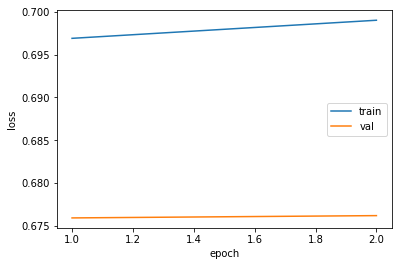

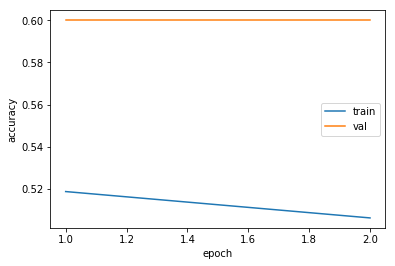

Training complete in 0m 21s
Validation 2

Epoch 1
---- train ----
Batch 1:	loss: 0.69191	 accuracy: 0.60000
Batch 3:	loss: 0.69488	 accuracy: 0.45000
Batch 4:	loss: 0.69286	 accuracy: 0.52500
Batch 5:	loss: 0.69134	 accuracy: 0.60000
Avg Loss: 0.69275	Avg Accuracy: 0.54375
-- validate --
Batch 2:	loss: 0.69521	 accuracy: 0.42500
A checkpoint was saved to ./checkpoints/checkpoint1_epoch1.pk

Epoch 2
---- train ----


KeyboardInterrupt: 

In [61]:
num_epochs=50
valNum=5
bestModels=[]
for mdl in range(1,4):
    for val in range(0,valNum):
        since = time.time()
        model, trn_loss, trn_acc, val_loss, val_acc, opt=initModel(mdl)
        maxAcc=0.0
        print('Validation {}'.format(val+1))
        for epoch in range(1, num_epochs+1):
            print('\nEpoch', epoch)
            model,trn_loss,trn_acc,val_loss,val_acc,bstMdl=epochsModel(model,opt,val,maxAcc,trn_loss,trn_acc,val_loss,val_acc,mdl)
        pltLoss(trn_loss, val_loss, num_epochs)
        pltAcc(trn_acc, val_acc, num_epochs)
        bestModels.append(bstMdl)
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [24]:
print(train_accuracy)

0.48125000298023224


Choose a model that you like best

In [170]:
prefered_checkpoint = 'C:/Users/showe/Documents/masters/SP18/CS8750/Project/code/data/checkpoints/checkpoint_epoch50.pk'
model.load_state_dict(torch.load(prefered_checkpoint))

Let your AI automatically recognize if there are birds in each images in test set

In [171]:
images = []
preds = []
model.eval()
for i, (input, target) in enumerate(tqdm(test_loader)):
    input, target = Variable(input, volatile=True), Variable(target)
    output = bstmdl(input)
    confidence = nn.functional.softmax(output, dim=1)
    confidence = confidence.cpu().data[0].numpy()
    if confidence[0] >= 0.5: # If the network predicts that the image contains a bird
        pred = 1
    else:
        pred = 0
    preds.append(pred)
    
    # Get the file name of the current image
    image = test_dataset.imgs[i]
    image = os.path.basename(image[0])
    images.append(image)
submission = pd.DataFrame({'image': images, 'has_bird': preds}, columns=['image', 'has_bird'])

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 49.16it/s]


Take a look at the first rows of the result.

In [172]:
submission.head()

,image,has_bird
0,0000.JPG,1
1,0001.JPG,0
2,0002.JPG,1
3,0003.JPG,0
4,0004.JPG,0


In [173]:
submission.to_csv(result_path, index=False)